# Experiment Pipeline

In [18]:
import os
from pathlib import Path
from configs import CONFIG_DIR
from figures import FIGURES_DIR

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from hubmap.data import DATA_DIR
from hubmap.dataset import transforms as T
from hubmap.dataset import TrainDataset, ValDataset

from hubmap.experiments.TransResUNet.utils import run
from hubmap.experiments.TransResUNet.utils import DiceBCELoss
from hubmap.experiments.TransResUNet.utils import visualize_detailed_results
from hubmap.experiments.TransResUNet.utils import visualize_detailed_results_overlay

from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.visualization import visualize_result

from hubmap.models.trans_res_u_net.model import TResUnet

In [19]:
NUM_EPOCHS = 200
BATCH_SIZE = 16
CHECKPOINT = "wide_resnet101_2_trial_0"
CONTINUE_TRAINING = False
PATIENCE = 20
LR = 1e-3
BACKBONE = "wide_resnet101_2"
PRETRAINED = True

In [32]:
FIGURES_CHECKPOINT_PATH = Path(FIGURES_DIR, "TransResUNet", f"{CHECKPOINT}")
os.makedirs(FIGURES_CHECKPOINT_PATH, exist_ok=True)

In [33]:
CHECKPOINT_FILE_NAME = f"{CHECKPOINT}.pt"
CHECKPOINT_NAME = Path("TransResUNet", CHECKPOINT_FILE_NAME)
config = {
    "num_epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "checkpoint_name": CHECKPOINT_NAME,
    "patience": PATIENCE,
    "lr": LR,
    "backbone": BACKBONE,
    "pretrained": PRETRAINED,
    "figures_directory": FIGURES_CHECKPOINT_PATH
}
os.makedirs(Path(CONFIG_DIR / CHECKPOINT_NAME).parent.resolve(), exist_ok=True)
torch.save(config, Path(CONFIG_DIR / CHECKPOINT_NAME))

In [4]:
train_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomCrop((256, 256)),
    ]
)

val_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256)),
    ]
)

In [5]:
train_set = TrainDataset(DATA_DIR, transform=train_transforms, with_background=True)
val_set = ValDataset(DATA_DIR, transform=val_transforms, with_background=True)

In [6]:
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=16
)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = TResUnet(num_classes=4, backbone=BACKBONE, pretrained=PRETRAINED)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = DiceBCELoss()
lr_scheduler = LRScheduler(optimizer, patience=PATIENCE)
early_stopping = None

result = run(
    num_epochs=NUM_EPOCHS,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    early_stopping=early_stopping,
    lr_scheduler=lr_scheduler,
    checkpoint_name=CHECKPOINT_NAME,
    continue_training=CONTINUE_TRAINING,
)

Epoch 1/50 - Summary: Train Loss: 0.6336 - Acc: 0.0160 --- Val Loss: 0.4623 - Acc: 0.0000
Epoch 2/50 - Summary: Train Loss: 0.2811 - Acc: 0.0000 --- Val Loss: 0.2226 - Acc: 0.0000
Epoch 3/50 - Summary: Train Loss: 0.2140 - Acc: 0.0204 --- Val Loss: 0.2282 - Acc: 0.0248
Epoch 4/50 - Summary: Train Loss: 0.1782 - Acc: 0.2106 --- Val Loss: 0.2098 - Acc: 0.0524
Epoch 5/50 - Summary: Train Loss: 0.1615 - Acc: 0.2700 --- Val Loss: 0.1710 - Acc: 0.1284
Epoch 6/50 - Summary: Train Loss: 0.1480 - Acc: 0.3191 --- Val Loss: 0.1412 - Acc: 0.2042
Epoch 7/50 - Summary: Train Loss: 0.1406 - Acc: 0.3568 --- Val Loss: 0.1213 - Acc: 0.3063
Epoch 8/50 - Summary: Train Loss: 0.1407 - Acc: 0.3609 --- Val Loss: 0.1317 - Acc: 0.3502
Epoch 9/50 - Summary: Train Loss: 0.1328 - Acc: 0.3878 --- Val Loss: 0.1202 - Acc: 0.3243
Epoch 10/50 - Summary: Train Loss: 0.1315 - Acc: 0.3867 --- Val Loss: 0.1112 - Acc: 0.3809
Epoch 11/50 - Summary: Train Loss: 0.1216 - Acc: 0.4087 --- Val Loss: 0.1131 - Acc: 0.3807
Epoch 12

<br>

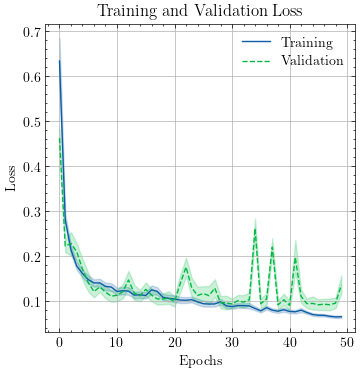

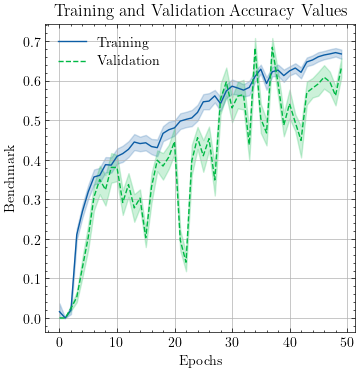

In [9]:
loss_fig, benchmark_fig = visualize_result(result)

In [31]:
loss_fig.savefig(Path(FIGURES_CHECKPOINT_PATH, "results_loss.png"))
benchmark_fig.savefig(Path(FIGURES_CHECKPOINT_PATH, "results_accuracy.png"))

In [23]:
data = iter(val_set)

In [24]:
image, target = next(data)

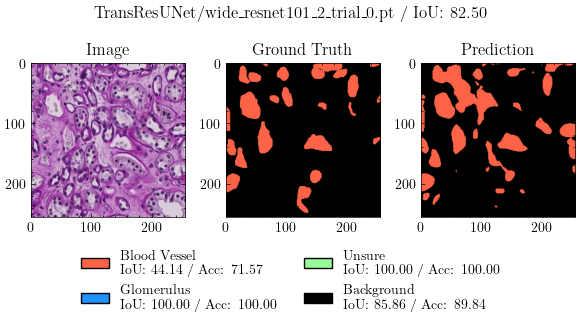

In [26]:
detailed = visualize_detailed_results(model, image, target, device, CHECKPOINT_NAME)

In [27]:
detailed.savefig(Path(FIGURES_CHECKPOINT_PATH, "example_results.png"))

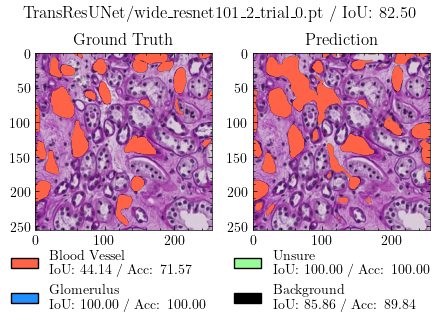

In [28]:
detailed_overlay = visualize_detailed_results_overlay(
    model, image, target, device, CHECKPOINT_NAME
)

In [29]:
detailed_overlay.savefig(Path(FIGURES_CHECKPOINT_PATH, "example_overlay.png"))

<br>